In [0]:

# the reference web of Colab with google drive : https://www.jianshu.com/p/ce2e63d1c10c
# 戴入檔案的方式， 
# COLAB  0:從Local端的路徑  
#       1:從Google Drive 中載入 

import os
from shutil import copyfile
from tqdm import tqdm
import time

IS_COLAB = 1

if IS_COLAB == 1:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
    !apt-get update -qq 2>&1 > /dev/null
    !apt-get -y install -qq google-drive-ocamlfuse fuse
    from google.colab import auth
    auth.authenticate_user()
    from oauth2client.client import GoogleCredentials
    creds = GoogleCredentials.get_application_default()
    import getpass
    !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
    vcode = getpass.getpass()
    !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

    !mkdir -p drive
    !google-drive-ocamlfuse drive

    # 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
    os.chdir("drive/Colab Notebooks/mpp/Identifying Malaria In Blood Imagery") 
    !ls
    
    # 將檔案從Google Drive複製一份至Cloab的本地Drive中，避免多次直接讀取Google Drive的檔案造成連線失敗的情況。
    print ("starting copy image files from google drive to local disk on colab ")
    HOME_DATA_DIR = os.path.join(os.path.abspath("/home"),"data")
    count=0
    if not os.path.exists(HOME_DATA_DIR):
      os.mkdir(HOME_DATA_DIR)
  
    denstination_list_dir = os.listdir(HOME_DATA_DIR)
    source_list_dir = os.listdir(".")
    
    # copy train data from google drive to the local disk of cloab 
    for dirpath, _ , filename in os.walk(os.path.join(os.path.abspath("."), "data-release/train")):  
      try:
        #for dirpath, _ , filename in os.walk(os.path.join(os.path.abspath("."), "data/train")):  
        #for i, f in enumerate(filename):
        x = tqdm(range(len(filename)))
        for i in x:
          dest_path = os.path.join(HOME_DATA_DIR,filename[i])
          if os.path.exists(dest_path) == False :
            copyfile(os.path.join(dirpath, filename[i]), os.path.join(HOME_DATA_DIR, filename[i]))      
          x.set_description("{}".format(filename[i]))
      except Exception as e:
        print ('Exception : '+ str(e))
      finally:
        x.close()

E: Package 'python-software-properties' has no installation candidate

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=h

00069.jpg: 100%|██████████| 21770/21770 [2:46:38<00:00,  1.91it/s]


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path as path
import gc
train_path = path.join(path.abspath('.'), "data-release/train_labels.csv")
train_dataframe = pd.read_csv(train_path) 

dataframe = train_dataframe[train_dataframe['infected'] == 1] 
train_image_path = np.array(dataframe['filename'][:10000])
train_labels = np.array(dataframe['infected'][:10000])

valid_image_path = np.array(dataframe['filename'][10000:])
valid_labels = np.array(dataframe['infected'][10000:])
 
dataframe = train_dataframe[train_dataframe['infected'] == 0]
train_image_path = np.append(train_image_path, np.array(dataframe['filename'][:10000]))
train_labels = np.append(train_labels, np.array(dataframe['infected'][:10000]))

valid_image_path = np.append(valid_image_path, np.array(dataframe['filename'][10000:]))
valid_labels = np.append(valid_labels, np.array(dataframe['infected'][10000:]))

del train_dataframe
del dataframe
gc.collect()

print ("train count:",len(train_labels))
print ("valid count:",len(valid_labels))

train count: 20000
valid count: 1765


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os, gc, psutil
import cv2

IMAGE_WIDTH = 128 
IMAGE_HEIGHT = 128
DISPLAY_IMAGE_ROW = 2
DISPLAY_IMAGE_COLUMN = 7
        
def display_image(image_list, is_infected, index_base=0 , title = "display image", save_image=False): 
    fig, ax = plt.subplots(figsize=(22 , 6))
    fig.subplots_adjust(hspace=0.4, wspace=0.1)
    
    for i in range(DISPLAY_IMAGE_ROW * DISPLAY_IMAGE_COLUMN):
        plt.subplot(2, DISPLAY_IMAGE_COLUMN, i + 1) 
        plt.imshow(keras.preprocessing.image.array_to_img(image_list[i+index_base]))
        # plt.imshow(image_list[i+index_base])
        plt.title("image : {}".format(is_infected[i+index_base]))
        plt.axis("off")
    
    # plt.imshow(band_1[i + index_base], cmap="gray")
    plt.suptitle(title) 
    
    if save_image:
        plt.savefig('{}.png'.format(title))

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import keras
import math
import random 

BATCH_SIZE = 32

def data_generator(dataset, set_batch_size, shuffle = True, is_augment = True, normalization = False):

    # 依據批次訓練的樣本數計算最少需要的批次的次數
    batch_count = math.floor(dataset[0].shape[0] / set_batch_size)
    
    # 實際可整除批次訓練數量的樣本數
    sample_data_len = batch_count * set_batch_size
    
    # 建立訓練資料的引索值        
    shuffle_data_index = np.arange(dataset[0].shape[0])
    
     # 設定新增訓練影像的相關參數
    if is_augment:
        image_augment = ImageDataGenerator(rotation_range=360, horizontal_flip=True, vertical_flip=True,fill_mode="constant" ,cval=0)
    else:
        image_augment = ImageDataGenerator()         
    
    while True: 
        # 重新排列資料索引順序
        if shuffle:
            np.random.shuffle(shuffle_data_index)           
     
        # 依據批次訓練的數量reshape資料索引的格式
        data_index = shuffle_data_index[0:set_batch_size * batch_count].reshape(-1,set_batch_size)        
       
        batch_image = [] 
        batch_is_bp = []  
        
        for epoch_index in range(batch_count):      
            batch_image.clear()
            batch_is_bp.clear()
            random_seed = np.random.randint(0, 1024)    
            for i, index in enumerate(data_index[epoch_index]):                
                full_path = path.join(path.abspath('./data-release/train'), dataset[0][index])                
                if not path.exists(full_path):                     
                    continue                  
                img = cv2.imread(full_path)                    
                batch_image.append(img)                 
                batch_is_bp.append(dataset[1][index])
                
            img_array = np.array(batch_image) 
            batch_gen = image_augment.flow(img_array , batch_size = set_batch_size, shuffle = False, seed = random_seed)  
            batch_img = next(batch_gen)
            
            if normalization:
                batch_img = batch_img/255            
            
            yield [batch_img], [np.array(batch_is_bp)]  

Using TensorFlow backend.


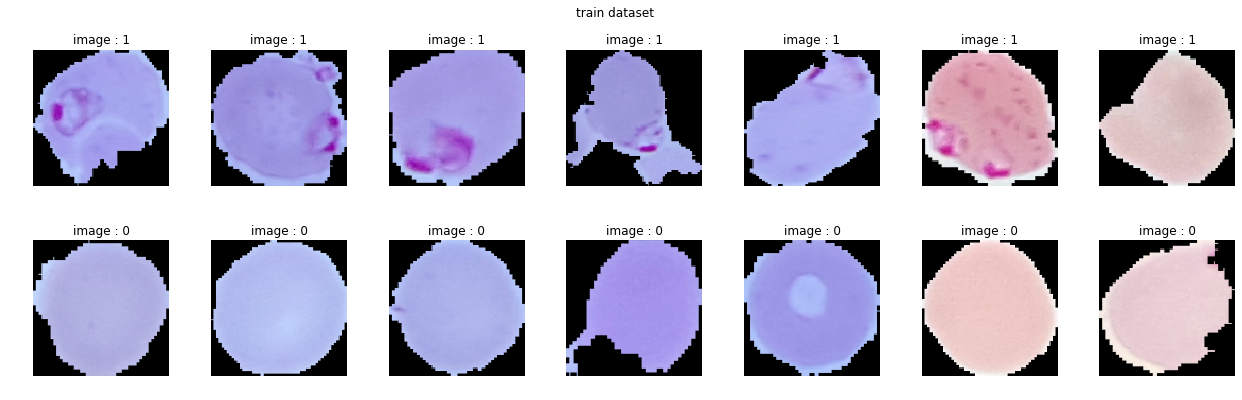

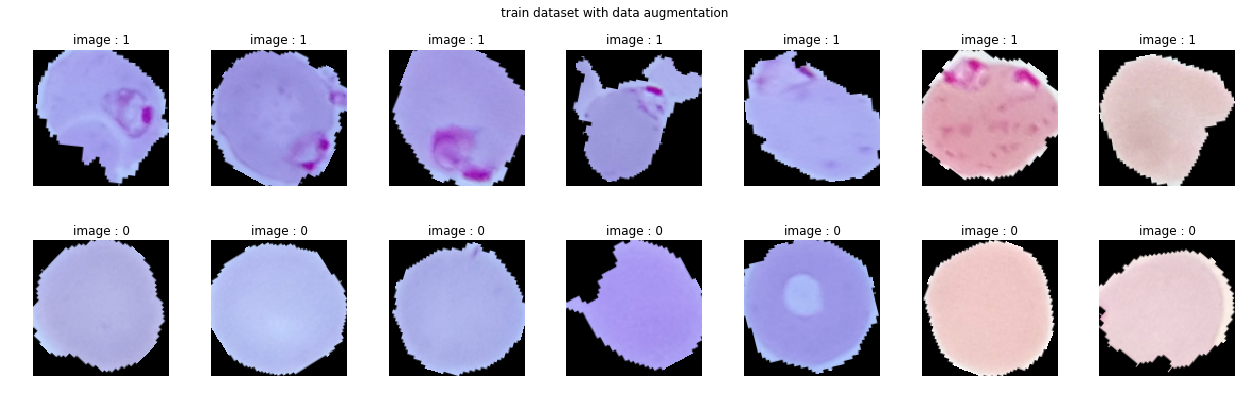

In [0]:
train_gen = data_generator((train_image_path[9993:10100], train_labels[9993:10100]), BATCH_SIZE, shuffle=False, is_augment= False, normalization = False)
batch_images, batch_labels = next(train_gen) 
display_image(batch_images[0], batch_labels[0], title="train dataset", index_base=0) # shuffle = True, is_augment = True

train_gen_augment = data_generator((train_image_path[9993:10100], train_labels[9993:10100]), BATCH_SIZE, shuffle=False, is_augment= True, normalization = False)
batch_images, batch_labels = next(train_gen_augment)
display_image(batch_images[0], batch_labels[0], title="train dataset with data augmentation", index_base=0) # shuffle = True, is_augment = True

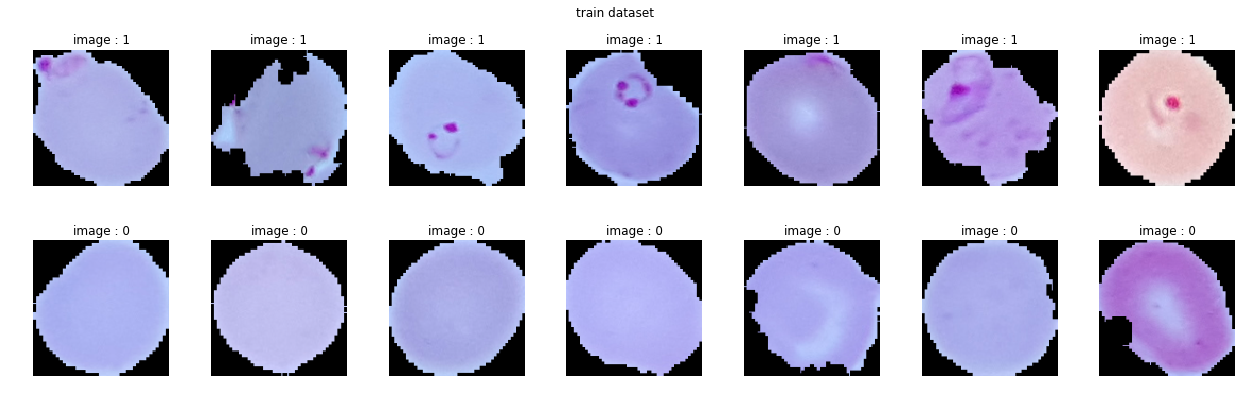

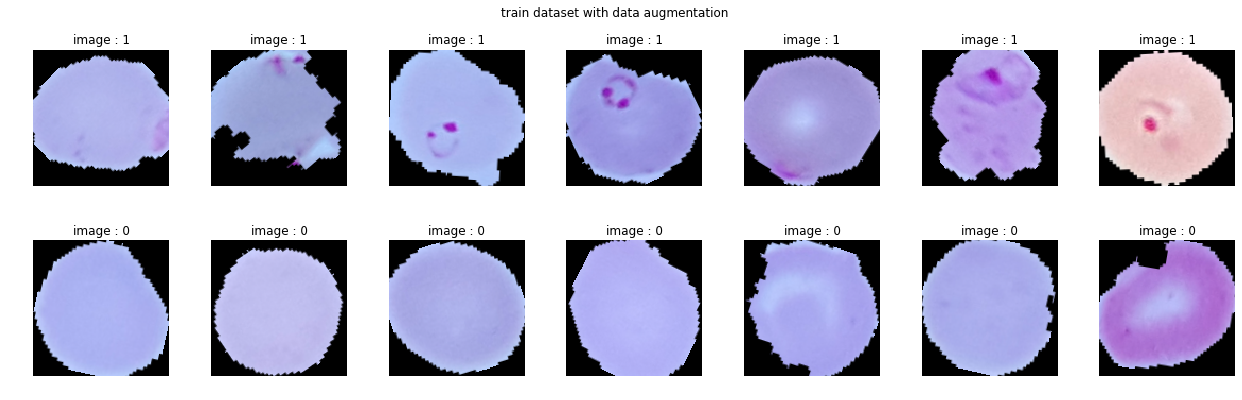

In [0]:
valid_gen = data_generator((valid_image_path[770:870], valid_labels[770:870]), BATCH_SIZE, shuffle=False, is_augment= False, normalization = False)
batch_images, batch_labels = next(valid_gen)
display_image(batch_images[0], batch_labels[0], title="train dataset", index_base=0)  

valid_gen_augment = data_generator((valid_image_path[770:870], valid_labels[770:870]), BATCH_SIZE, shuffle=False, is_augment= True, normalization = False)
batch_images, batch_labels = next(valid_gen_augment)
display_image(batch_images[0], batch_labels[0], title="train dataset with data augmentation", index_base=0)  

In [0]:
import keras
import keras.layers as KL
import keras.models as KM
from keras.utils.vis_utils import plot_model

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
def use_customized_network(save_graphic=False):
    
    image_input = keras.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], dtype="float32")      
    
    x = KL.Conv2D(64, (3,3), padding="same", strides= 2)(image_input)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)    
    x = KL.Dropout(0.5)(x)
    
    x = KL.Conv2D(128, (3,3), padding="same", strides = 2)(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    x = KL.Dropout(0.5)(x)
        
    x = KL.Conv2D(256, (3,3), padding="same", strides = 2)(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    x = KL.Dropout(0.5)(x)
        
    x = KL.Conv2D(512, (1,1), padding="same", strides = 2)(x)
    x = KL.BatchNormalization()(x)
    x = KL.Activation("relu")(x)
    x = KL.Dropout(0.5)(x)
        
    x = KL.GlobalAveragePooling2D()(x)  
    x = KL.Dropout(0.5)(x)
    x = KL.Dense(64, activation='relu')(x)     
  
    merge_output = KL.Dense(1, activation='sigmoid')(x)

    model = KM.Model (inputs = [image_input], outputs = [merge_output], name='predict_iceberg')
 
    optimizer_adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.2)

    #model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
  
    model.summary()
    
    if save_graphic: 
      # Create model object in inference mode. inference training
      plot_model(model, to_file="identifying_malaria.png", show_shapes=True, show_layer_names=True)
    return model  


In [0]:
train_gen_augment = data_generator((train_image_path, train_labels), BATCH_SIZE, shuffle=True, is_augment= True, normalization = True)
valid_gen_augment = data_generator((valid_image_path, valid_labels), BATCH_SIZE, shuffle=True, is_augment= True, normalization = True)

In [0]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,CSVLogger, ReduceLROnPlateau, EarlyStopping

#建立模型進行辨識圖片中是否有Brachial Plexus的問題

np.random.seed(7718)

log_dir = os.path.join( path.abspath("."), "logs")
NAME = "identifying_malaria"

# Path to save after each epoch. Include placeholders that get filled by Keras.
save_model_path = os.path.join(log_dir, "{}_*epoch*_*loss*.h5".format(NAME.lower()))    
save_model_path = save_model_path.replace("*epoch*", "{epoch:04d}")
save_model_path = save_model_path.replace("*loss*", "{val_loss:04f}") 

save_log_path = os.path.join(log_dir, "{}_loss.csv".format(NAME.lower()))
if os.path.exists(save_log_path):
    os.remove(save_log_path)
  
    #earlystop = EarlyStopping(monitor='val_loss', patience=50, mode='auto')
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto', min_delta=0.001, cooldown=0, min_lr=0.00001)  
msave = ModelCheckpoint(save_model_path, monitor='val_loss', mode='min', save_best_only=False, save_weights_only=False)
csv = CSVLogger(save_log_path, append=True)

load_model_path = os.path.join(log_dir, "identifying_malaria_{:04}.h5".format(20))
print (load_model_path)

if path.exists(load_model_path):  
    model = load_model(load_model_path)
else:    
    print("load last model")
    model = use_customized_network(save_graphic=True)
        
model.fit_generator(
            train_gen_augment ,
            initial_epoch = 20,
            epochs = 50,
            steps_per_epoch= 100,
            callbacks = [csv, msave, reducelr], #earlystop
            validation_data = valid_gen_augment,
            validation_steps = 20,
            max_queue_size = 100,
            workers = 0, # only for windows 
            use_multiprocessing=True)


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

from sklearn.metrics import roc_curve, auc

def display_roc_curve(predict_result, target_result, caption="Receiver Operating Characteristic Curve"):  
    fpr, tpr, _ = roc_curve(target_result, predict_result)   
    label_list = "area under curve :{}".format(round(auc(fpr, tpr),2))
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label= label_list) 
    plt.plot([0.0,1],[0,1], color='navy',lw=2)   
    plt.xlim([0.0, 1.0])  # 設定X軸的刻度
    plt.ylim([0.0, 1.02]) # 設定Y軸的刻度且為了避免1.0的線與圖的外框相連，因此多出0.02
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
    plt.legend(loc='lower right') # 設定線段說明的位置
    plt.show()

def display_mulit_roc_curve(dictargs, caption ):  
    plt.figure()
    plt.plot([0.0,1],[0,1], color='navy',lw=2)   
    plt.xlim([0.0, 1.0])  # 設定X軸的刻度
    plt.ylim([0.0, 1.02]) # 設定Y軸的刻度且為了避免1.0的線與圖的外框相連，因此多出0.02
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
     
    line_color=['darkorange', 'black', 'green', "black", "red", "cyan", "yellow", "magenta"]
    
    for i, key in enumerate(dictargs):
        val = dictargs.get(key)         
        fpr, tpr, _ = roc_curve(val[0], val[1])
        roc_auc = round(auc(fpr, tpr),2)      
        plt.plot(fpr, tpr, color=line_color[i], lw=2, label= "{} auc :{}".format(key,roc_auc)) 
      
    plt.legend(loc='lower right')  
    plt.show()
    
def display_error_image(images, targets, predicts, display_indexs, title ="diisplay error image" ):  
    fig, ax = plt.subplots(figsize=(22 , 6))
    fig.subplots_adjust(hspace=0.4, wspace=0.1)   
 
    for i, index in enumerate(display_indexs):
        if (i >= DISPLAY_IMAGE): break;
        plt.subplot(2, DISPLAY_IMAGE, i + 1)       
        plt.title("image:{}-{:.8f}".format(targets[index][0], predicts[index][0]))
        plt.axis("off")
        plt.imshow(images[index]) # , cmap=""
   
    for i, index in enumerate(display_indexs): 
        if (i >= DISPLAY_IMAGE): break;
        plt.subplot(2, DISPLAY_IMAGE, i + DISPLAY_IMAGE + 1)      
        plt.title("image:{}-{:.8f}".format(targets[index][0], predicts[index][0])) 
        plt.axis("off")  
        plt.imshow(images[index]) ## , cmap=""
    
    plt.suptitle = title

In [0]:
# 設定模型的檔案路徑及載入模型
import os
from keras.models import load_model
FILE_NAME = "identifying_malaria"
log_dir = os.path.join( path.abspath("."), "logs")

model_path = os.path.join(log_dir, "identifying_malaria_{:04}.h5".format(38))
if not path.exists(model_path):   
    print (model_path)    
    raise ValueError ("File is not exists. - {}".format(model_path))

predict_model = load_model(model_path)
predict_model.summary()

In [0]:
# 評估模型
roc_dict={}
data_result = []

# 評估Train Dataset的loss值及正確率
print ("=== Train Dataset ===")
time.sleep(1)
loss_value = 0
accuray_value = 0 
roc_dict["train"] = [[],[]]
try:
  x = tqdm(range(len(train_image_path)))    
  for index in x:
    full_path = path.join(path.abspath('./data-release/train'), train_image_path[index])                
    if path.exists(full_path):         
      img = cv2.imread(full_path) 
      img = img / 255
      img = np.expand_dims(img, axis=0)           
      predict = predict_model.predict(x=img)            
      roc_dict['train'][0].append(train_labels[index]) 
      roc_dict['train'][1].append(predict[0])               
      image_label = np.expand_dims(train_labels[index], axis=0)            
      predict_result = predict_model.evaluate(x=img, y=image_label, batch_size=1, verbose=0)  
      loss_value = loss_value + predict_result[0]  
      accuray_value = accuray_value + predict_result[1]   
         
except Exception as ex:
  print ("Exception:" + str(ex))
finally:
  x.close() 
  print ("loss : ", loss_value/len(train_image_path))
  print ("accuracy :", accuray_value/len(train_image_path))

time.sleep(1)

# 評估Validation Dataset的loss值及正確率
print ("=== Validation Dataset ===")
time.sleep(1)
loss_value = 0
accuray_value = 0 
roc_dict["valid"] = [[],[]]
try:
  y = tqdm(range(len(valid_image_path)))   
  for index in y:
    full_path = path.join(path.abspath('./data-release/train'), valid_image_path[index])                
    if path.exists(full_path):                     
      img = cv2.imread(full_path)  
      img = img /255
      img = np.expand_dims(img, axis=0) 
      predict = predict_model.predict(x=img)
      roc_dict['valid'][0].append(valid_labels[index])     
      roc_dict['valid'][1].append(predict[0])
            
      image_label = np.expand_dims(valid_labels[index], axis=0)
      predict_result = predict_model.evaluate(x=img, y=image_label, batch_size=1, verbose=0)          
      loss_value = loss_value + predict_result[0]  
      accuray_value = accuray_value + predict_result[1]  
except Exception as ex:
  print ("exception:" + str(ex))
finally:
  y.close()
  print ("loss : ", loss_value/len(valid_image_path))
  print ("accuracy :", accuray_value/len(valid_image_path))

# 建立ROC Curve (Receiver Operating Characteristic Curve)
display_mulit_roc_curve(roc_dict, caption="the ROC curve of train data")

In [0]:
import seaborn as sn  
from sklearn.metrics import classification_report, confusion_matrix
 
target_names = ['uninfected', 'infected'] 
print ("=== the confusion matrix of train data ====")
infected_classify = [0 if prob[0] < 0.5 else 1 for prob in roc_dict["train"][1]]
 
cm = confusion_matrix(y_true=train_labels, y_pred=infected_classify)
print(pd.DataFrame(cm, columns=target_names))
print(classification_report(train_labels, infected_classify, target_names=target_names)) 
  
print ("=== the confusion matrix of valid data ====") 
infected_classify = [0 if prob[0] < 0.5 else 1 for prob in roc_dict["valid"][1]]
cm = confusion_matrix(y_true=valid_labels, y_pred=infected_classify)
print (pd.DataFrame(cm, columns=target_names))
print (classification_report(valid_labels, infected_classify, target_names=target_names)) 


In [0]:
# 使用資料增強的方式產生Test Dataset進行評估loss值及正確率
print ("=== Test Dataset ===")
TEST_ECPOHS = 8
test_gen =  data_generator((valid_image_path, valid_labels), 1024, shuffle=True, is_augment= True, normalization=True)
Average_Loss = 0
Average_Accuracy = 0
roc_dict ={}
total_predict = []
total_target = []
for i in range (TEST_ECPOHS):
    print ("=== Round {} ===".format(i+1))  
    test_data , test_ans = next(test_gen)   
    total_target.extend(test_ans[0])    
    # 使用predict方法取得判斷的機率值並存至roc_dict字典物件
    predict_result = predict_model.predict(x=test_data)
    total_predict.extend(predict_result)
    key = "round {}".format(i+1)
    roc_dict[key] = (test_ans[0], predict_result)
  
    # 使用predict方法取得判斷的機率值
    predict_result = predict_model.evaluate(x=test_data, batch_size=1024 , y=test_ans)  
    print ("loss : ", predict_result[0])
    print ("accuracy :", predict_result[1])
  
    Average_Loss += predict_result[0]
    Average_Accuracy += predict_result[1]

print ("=== Average evaluate ===")
print ("loss : ", Average_Loss / TEST_ECPOHS)
print ("accuracy :",Average_Accuracy / TEST_ECPOHS)

# 建立ROC Curve (Receiver Operating Characteristic Curve)
display_mulit_roc_curve(roc_dict, caption="the roc curve of test data")


In [0]:
import seaborn as sn  
from sklearn.metrics import classification_report, confusion_matrix 
target_names = ['uninfected', 'infected' ] 
print ("=== the confusion matrix of test data ====")
iceberg_classify = [0 if prob[0] < 0.5 else 1  for prob in total_predict ] 
confusion_matrix = confusion_matrix(y_true=total_target, y_pred=iceberg_classify)
print(pd.DataFrame(confusion_matrix, columns=target_names))
print(classification_report(total_target, iceberg_classify, target_names=target_names)) 
 

In [0]:
import os
from tqdm import tqdm
import os.path as path
image_files = []
predict_result = []
test_path = path.abspath("./data-release/test")
print(test_path)
for root, dirs, files in os.walk(test_path): 
  try:
    files = sorted(files, reverse=False)
    x = tqdm(range(len(files)))
    for index in x:
      full_path = path.join(root, files[index])
      img = cv2.imread(full_path)
      img = img / 255    
      img  = np.expand_dims(img, axis = 0)
      predict = predict_model.predict(x=img)
      predict_result.append(predict[0][0])
      image_files.append(files[index])           
  except Exception as ex: 
    print ("exception:", str(ex))
  finally:
    x.close()

In [0]:
import datetime
import pandas as pd
save_file = "malaria_submission_{:%Y%m%d_%H%M}.csv".format(datetime.datetime.now())
print (save_file)

save_result = pd.DataFrame()
save_result['filename'] = image_files
save_result['infected'] = predict_result
save_result.to_csv(save_file, index=False)
print(save_result.head())
